### imports

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
import torchvision.transforms as T
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np

from torchdiffeq import odeint

from neuralop.models import FNO2d, FNO

from ndo_utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((64, 64)),
])

dataset = MNIST(root="data", train=True, download=True, transform=transform)
images = torch.stack([dataset[i][0].squeeze() for i in range(300)])  # (100,64,64)

In [14]:
kappa = 0.05
T_final = 100
dt = 0.5
dx = 1.0

In [ ]:
u0_batch = images
ut_trajectory_batch = torch.stack([
    torch.stack(solve_heat_neumann(u0, kappa=kappa, T=T_final, dt=dt, dx=dx))
    for u0 in u0_batch
])
ut_final_batch = ut_trajectory_batch[:, -1, :, :]

In [6]:
dataset_test = MNIST(root="data", train=False, download=True, transform=transform)
images_test = torch.stack([dataset_test[i][0].squeeze() for i in range(300)])  # (100,64,64)

In [7]:
u0_batch_test = images_test
ut_trajectory_batch_test = torch.stack([
    torch.stack(solve_heat_neumann(u0, kappa=kappa, T=T_final, dt=dt, dx=dx))
    for u0 in u0_batch_test
])
ut_final_batch_test = ut_trajectory_batch_test[:, -1, :, :]

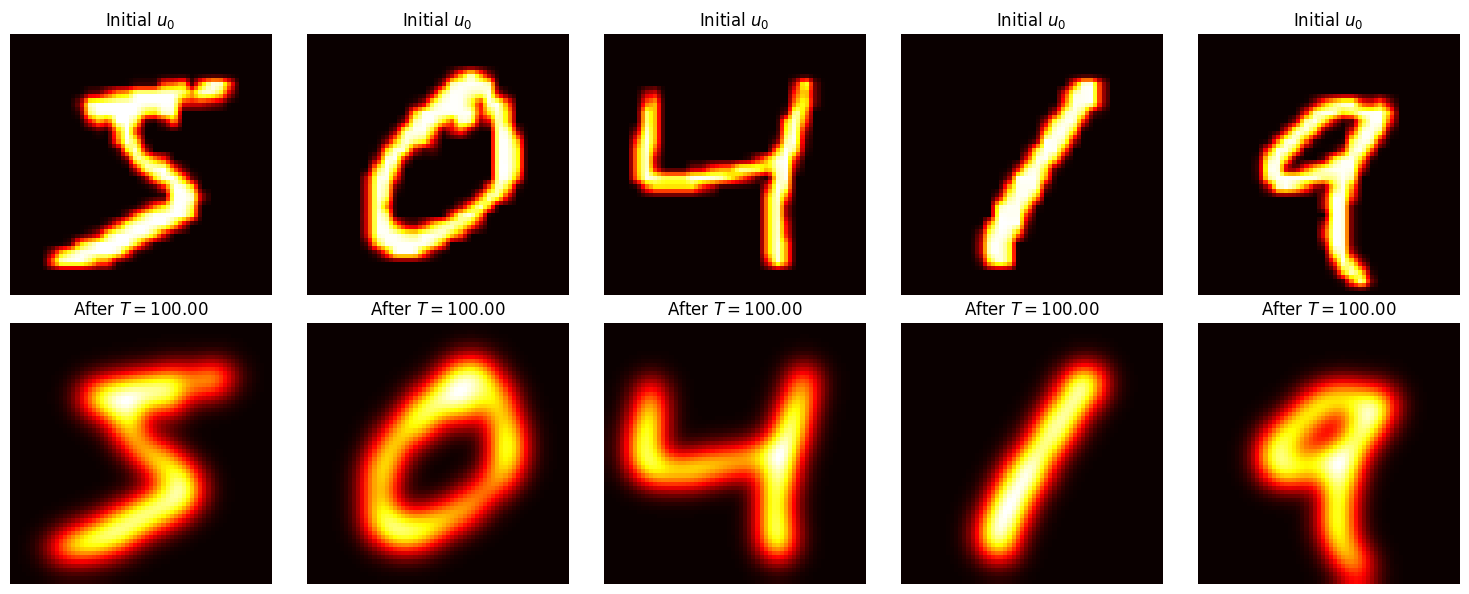

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axs[0,i].imshow(u0_batch[i].numpy(), cmap='hot')
    axs[0,i].set_title('Initial $u_0$')
    axs[0,i].axis('off')
    axs[1,i].imshow(ut_final_batch[i].numpy(), cmap='hot')
    axs[1,i].set_title('After $T=%.2f$' % T_final)
    axs[1,i].axis('off')
plt.tight_layout()
plt.show()

In [9]:
torch.save({
    'u0': u0_batch,
    'ut_trajectory': ut_trajectory_batch,
    'ut_final': ut_final_batch,
}, './data/heat_dataset_train.pt')

In [10]:
torch.save({
    'u0': u0_batch_test,
    'ut_trajectory': ut_trajectory_batch_test,
    'ut_final': ut_final_batch_test,
}, './data/heat_dataset_test.pt')

### NDO training

In [ ]:
data_train = torch.load('./data/heat_dataset_train.pt')
u0_train = data_train['u0']
ut_trajectory_train = data_train['ut_trajectory']
ut_final_train = data_train['ut_final']


u0_train = u0_train.unsqueeze(1).to(device)
ut_final_train = ut_final_train.unsqueeze(1).to(device)

dataset = TensorDataset(ut_final_train, u0_train)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = InverseHeatNDO(modes=(16,16), hidden_channels=32, atol=1e-5, rtol=1e-5).to(device)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn   = torch.nn.MSELoss()
num_epochs = 50

In [8]:
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0

    for ut_batch, u0_batch in dataloader:
        torch.cuda.empty_cache()

        u0_pred = model(ut_batch, s_span=torch.tensor([0.0, 1.0], device=device))

        loss = loss_fn(u0_pred[-1], u0_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * ut_batch.size(0)

    epoch_loss /= len(dataloader.dataset)
    print(f'epoch {epoch:2d}/{num_epochs} — L2 loss: {epoch_loss:.4e}')

epoch  1/50 — L2 loss: 1.5588e-02
epoch  2/50 — L2 loss: 1.3234e-02
epoch  3/50 — L2 loss: 8.6515e-03
epoch  4/50 — L2 loss: 4.8431e-03
epoch  5/50 — L2 loss: 2.8755e-03
epoch  6/50 — L2 loss: 2.0002e-03
epoch  7/50 — L2 loss: 1.6171e-03
epoch  8/50 — L2 loss: 1.4288e-03
epoch  9/50 — L2 loss: 1.2811e-03
epoch 10/50 — L2 loss: 1.1661e-03
epoch 11/50 — L2 loss: 1.0924e-03
epoch 12/50 — L2 loss: 1.0431e-03
epoch 13/50 — L2 loss: 1.0029e-03
epoch 14/50 — L2 loss: 9.5879e-04
epoch 15/50 — L2 loss: 9.2224e-04
epoch 16/50 — L2 loss: 8.8952e-04
epoch 17/50 — L2 loss: 8.5762e-04
epoch 18/50 — L2 loss: 8.2492e-04
epoch 19/50 — L2 loss: 7.9710e-04
epoch 20/50 — L2 loss: 7.7117e-04
epoch 21/50 — L2 loss: 7.5192e-04
epoch 22/50 — L2 loss: 7.2995e-04
epoch 23/50 — L2 loss: 7.1437e-04
epoch 24/50 — L2 loss: 6.9832e-04
epoch 25/50 — L2 loss: 6.8106e-04
epoch 26/50 — L2 loss: 6.6944e-04
epoch 27/50 — L2 loss: 6.6309e-04
epoch 28/50 — L2 loss: 6.5040e-04
epoch 29/50 — L2 loss: 6.3481e-04
epoch 30/50 — 

In [13]:
torch.save(model.state_dict(), './data/inverse_heat_ndo.pth')

### FNO training

In [18]:
ut_trajectory_train = ut_trajectory_train.unsqueeze(1).to(device)

trajectory_dataset = TensorDataset(ut_trajectory_train)
batch_size = 16
trajectory_dataloader = DataLoader(trajectory_dataset, batch_size=batch_size, shuffle=True)

In [10]:
fno = FNO2d(
            in_channels=1,
            out_channels=1,
            n_modes_width=16,
            n_modes_height=16,
            hidden_channels=32,
        ).to(device=device)

In [11]:
optimizer = torch.optim.Adam(fno.parameters(), lr=1e-3)
loss_fn   = torch.nn.MSELoss()
num_epochs = 50

In [ ]:
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0

    for trajectory_batch in trajectory_dataloader:
        torch.cuda.empty_cache()

        for ii in range(1, trajectory_batch[0].shape[2]):

            pred = fno(trajectory_batch[0][:, :, ii, ...])

            loss = loss_fn(pred, trajectory_batch[0][:, :, ii - 1, ...])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

    epoch_loss /= (len(trajectory_dataloader.dataset) * trajectory_batch[0].shape[2])
    print(f'epoch {epoch:2d}/{num_epochs} — L2 loss: {epoch_loss:.4e}')

epoch  1/50 — L2 loss: 3.7492e-05
epoch  2/50 — L2 loss: 1.7774e-07
epoch  3/50 — L2 loss: 1.5893e-07
epoch  4/50 — L2 loss: 1.2117e-07
epoch  5/50 — L2 loss: 1.1663e-07
epoch  6/50 — L2 loss: 4.8928e-08
epoch  7/50 — L2 loss: 7.0715e-08
epoch  8/50 — L2 loss: 5.3194e-08
epoch  9/50 — L2 loss: 8.0561e-08
epoch 10/50 — L2 loss: 4.7663e-08
epoch 11/50 — L2 loss: 3.5946e-08
epoch 12/50 — L2 loss: 3.8532e-08
epoch 13/50 — L2 loss: 3.4954e-08
epoch 14/50 — L2 loss: 4.9839e-08
epoch 15/50 — L2 loss: 2.9176e-08
epoch 16/50 — L2 loss: 2.8929e-08
epoch 17/50 — L2 loss: 2.6590e-08
epoch 18/50 — L2 loss: 2.5719e-08
epoch 19/50 — L2 loss: 3.1360e-08
epoch 20/50 — L2 loss: 3.2145e-08
epoch 21/50 — L2 loss: 1.7931e-08
epoch 22/50 — L2 loss: 2.4628e-08
epoch 23/50 — L2 loss: 2.1673e-08
epoch 24/50 — L2 loss: 2.1078e-08
epoch 25/50 — L2 loss: 2.3282e-08
epoch 26/50 — L2 loss: 2.3269e-08
epoch 27/50 — L2 loss: 2.1309e-08
epoch 28/50 — L2 loss: 1.9984e-08
epoch 29/50 — L2 loss: 1.8162e-08
epoch 30/50 — 

In [14]:
torch.save(fno.state_dict(), './data/inverse_heat_fno.pth')

### CNN training

In [8]:
cnn = SimpleConvNet().to(device=device)

In [9]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3)
loss_fn   = torch.nn.MSELoss()
num_epochs = 20

In [ ]:
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0

    for trajectory_batch in trajectory_dataloader:

        for ii in range(1, trajectory_batch[0].shape[2]):

            pred = cnn(trajectory_batch[0][:, :, ii, ...])

            loss = loss_fn(pred, trajectory_batch[0][:, :, ii - 1, ...])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

    epoch_loss /= (len(trajectory_dataloader.dataset) * trajectory_batch[0].shape[2])
    print(f'epoch {epoch:2d}/{num_epochs} — L2 loss: {epoch_loss:.4e}')

epoch  1/20 — L2 loss: 1.2379e-06
epoch  2/20 — L2 loss: 2.9108e-08
epoch  3/20 — L2 loss: 8.6159e-09
epoch  4/20 — L2 loss: 5.0290e-09
epoch  5/20 — L2 loss: 1.0336e-06
epoch  6/20 — L2 loss: 2.6030e-08
epoch  7/20 — L2 loss: 2.1725e-07
epoch  8/20 — L2 loss: 1.5049e-08
epoch  9/20 — L2 loss: 4.0870e-08
epoch 10/20 — L2 loss: 5.8603e-08
epoch 11/20 — L2 loss: 1.4857e-08
epoch 12/20 — L2 loss: 4.3335e-08
epoch 13/20 — L2 loss: 3.5647e-09
epoch 14/20 — L2 loss: 3.4960e-09
epoch 15/20 — L2 loss: 1.2426e-07
epoch 16/20 — L2 loss: 2.4450e-07
epoch 17/20 — L2 loss: 4.7849e-08
epoch 18/20 — L2 loss: 1.0683e-08
epoch 19/20 — L2 loss: 1.1116e-07
epoch 20/20 — L2 loss: 1.3462e-08


In [11]:
torch.save(cnn.state_dict(), './data/inverse_heat_cnn.pth')

### other stuff

In [ ]:
examples_NDO = []

with torch.no_grad():
    for uT_batch, u0_batch in dataloader:
        noise = torch.randn_like(uT_batch)
        noise = noise * 0.1 * torch.norm(uT_batch, p=2, dim=(1,2,3), keepdim=True) / torch.norm(noise, p=2, dim=(1,2,3), keepdim=True)
        u0_pred = model(uT_batch + noise, s_span=torch.tensor([0.0, 0.2, 0.4, 0.6, 0.8, 1.], device=device))

        if len(examples_NDO) < 4:
            examples_NDO.append((u0_batch.cpu(), u0_pred.cpu(), uT_batch.cpu()))

In [39]:
examples_CNN = []
with torch.no_grad():
    for uT_batch, u0_batch in dataloader:
        noise = torch.randn_like(uT_batch)
        noise = noise * 0.05 * torch.norm(uT_batch, p=2, dim=(1,2,3), keepdim=True) / torch.norm(noise, p=2, dim=(1,2,3), keepdim=True)
        u0_pred = uT_batch + noise
        for ii in range(200):
            u0_pred = cnn(u0_pred)
        


        if len(examples_CNN) < 4:
            examples_CNN.append((u0_batch.cpu(), u0_pred.cpu(), uT_batch.cpu()))

In [53]:
examples_FNO = []
with torch.no_grad():
    for uT_batch, u0_batch in dataloader:
        noise = torch.randn_like(uT_batch)
        noise = noise * 0.05 * torch.norm(uT_batch, p=2, dim=(1,2,3), keepdim=True) / torch.norm(noise, p=2, dim=(1,2,3), keepdim=True)
        u0_pred = uT_batch + noise
        for ii in range(100):
            u0_pred = fno(u0_pred)

        if len(examples_FNO) < 4:
            examples_FNO.append((u0_batch.cpu(), u0_pred.cpu(), uT_batch.cpu()))

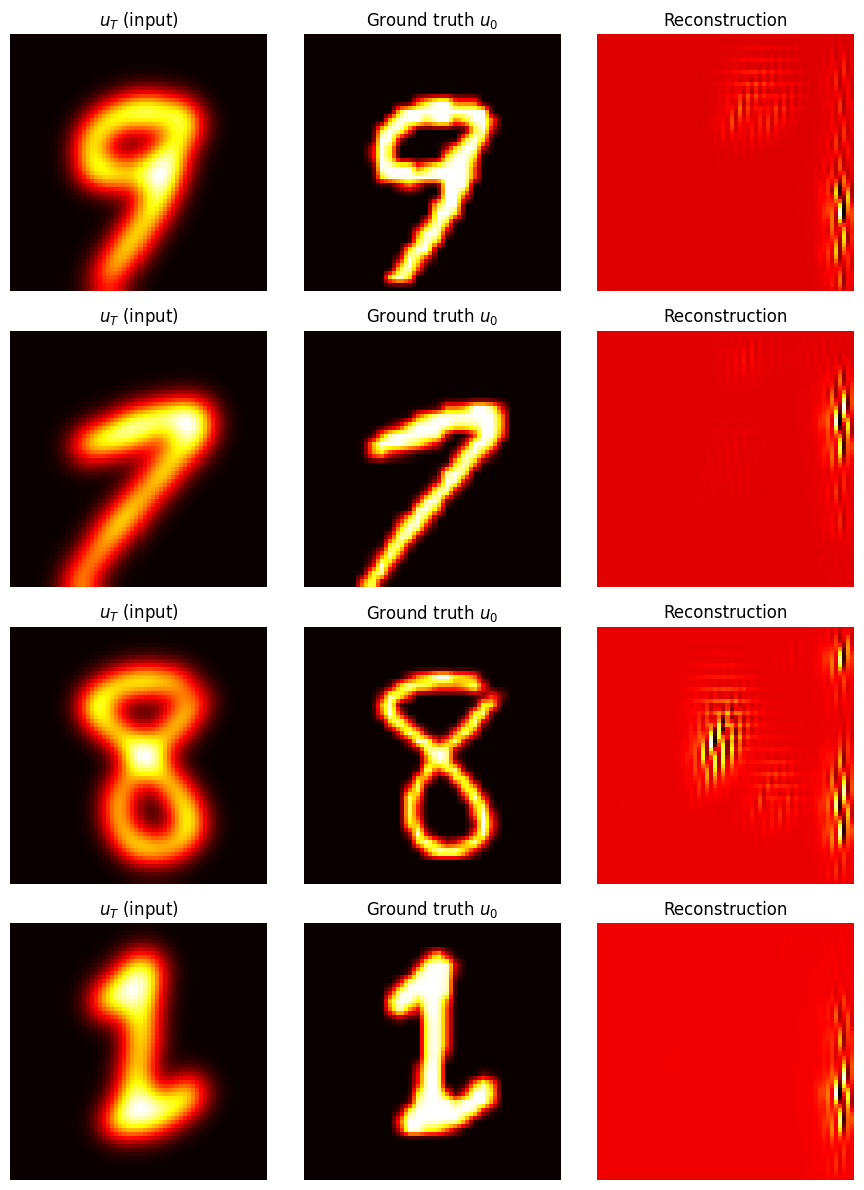

In [41]:
fig, axes = plt.subplots(len(examples_CNN), 3, figsize=(9, 3*len(examples_CNN)))
for i, (u0_true, u0_pred, uT) in enumerate(examples_CNN):
    axes[i,0].imshow(uT[0,0], cmap='hot')
    axes[i,0].set_title('$u_T$ (input)')
    axes[i,1].imshow(u0_true[0,0], cmap='hot')
    axes[i,1].set_title('Ground truth $u_0$')
    axes[i,2].imshow(u0_pred[0,0], cmap='hot')
    axes[i,2].set_title('Reconstruction')
    for ax in axes[i]:
        ax.axis('off')
plt.tight_layout()
plt.show()